In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('drive/MyDrive/Colab/Task3')

In [ ]:
!nvidia-smi

## 1.数据处理

### 1.1 数据预处理

In [ ]:
import zipfile

original_zip_file = zipfile.ZipFile('dataset/snli_1.0.zip')
original_zip_file.namelist()

['snli_1.0/',
 'snli_1.0/.DS_Store',
 '__MACOSX/',
 '__MACOSX/snli_1.0/',
 '__MACOSX/snli_1.0/._.DS_Store',
 'snli_1.0/Icon\r',
 '__MACOSX/snli_1.0/._Icon\r',
 'snli_1.0/README.txt',
 '__MACOSX/snli_1.0/._README.txt',
 'snli_1.0/snli_1.0_dev.jsonl',
 'snli_1.0/snli_1.0_dev.txt',
 'snli_1.0/snli_1.0_test.jsonl',
 'snli_1.0/snli_1.0_test.txt',
 'snli_1.0/snli_1.0_train.jsonl',
 'snli_1.0/snli_1.0_train.txt',
 '__MACOSX/._snli_1.0']

In [ ]:
import pandas as pd

with original_zip_file.open('snli_1.0/snli_1.0_dev.txt') as fp:
    data_example = pd.read_csv(fp, sep='\t')
data_example

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( Two women ) ( ( are ( embracing ( while ( ...,( ( The sisters ) ( ( are ( ( hugging goodbye ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (DT The) (NNS sisters)) (VP (VBP ...,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,4705552913.jpg#2,4705552913.jpg#2r1n,neutral,entailment,neutral,neutral,neutral
1,entailment,( ( Two women ) ( ( are ( embracing ( while ( ...,( ( Two woman ) ( ( are ( holding packages ) )...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (CD Two) (NN woman)) (VP (VBP are...,Two women are embracing while holding to go pa...,Two woman are holding packages.,4705552913.jpg#2,4705552913.jpg#2r1e,entailment,entailment,entailment,entailment,entailment
2,contradiction,( ( Two women ) ( ( are ( embracing ( while ( ...,( ( The men ) ( ( are ( fighting ( outside ( a...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (DT The) (NNS men)) (VP (VBP are)...,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,4705552913.jpg#2,4705552913.jpg#2r1c,contradiction,contradiction,contradiction,contradiction,contradiction
3,entailment,( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,( ( ( Two kids ) ( in ( numbered jerseys ) ) )...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,2407214681.jpg#0,2407214681.jpg#0r1e,entailment,entailment,entailment,entailment,entailment
4,neutral,( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,( ( ( Two kids ) ( at ( a ballgame ) ) ) ( ( w...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,2407214681.jpg#0,2407214681.jpg#0r1n,neutral,neutral,neutral,entailment,entailment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-,( ( ( A ( small girl ) ) ( wearing ( a ( pink ...,( ( The girl ) ( ( is ( sitting ( on ( ( a ( c...,(ROOT (S (NP (NP (DT A) (JJ small) (NN girl)) ...,(ROOT (S (NP (DT The) (NN girl)) (VP (VBZ is) ...,A small girl wearing a pink jacket is riding o...,The girl is sitting on a carved horse made of ...,77063034.jpg#3,77063034.jpg#3r1n,neutral,contradiction,entailment,contradiction,NaN
9996,contradiction,( ( ( A ( small girl ) ) ( wearing ( a ( pink ...,( ( The girl ) ( ( is ( moving ( at ( ( the sp...,(ROOT (S (NP (NP (DT A) (JJ small) (NN girl)) ...,(ROOT (S (NP (DT The) (NN girl)) (VP (VBZ is) ...,A small girl wearing a pink jacket is riding o...,The girl is moving at the speed of light.,77063034.jpg#3,77063034.jpg#3r1c,contradiction,contradiction,contradiction,contradiction,contradiction
9997,entailment,( ( ( A ( young girl ) ) ( with ( ( ( ( ( ( bl...,( People ( in ( a ( water fountain ) ) ) ),(ROOT (NP (NP (DT A) (JJ young) (NN girl)) (PP...,(ROOT (NP (NP (NNS People)) (PP (IN in) (NP (D...,A young girl with blue and pink ribbons in her...,People in a water fountain,4805835848.jpg#0,4805835848.jpg#0r1e,entailment,entailment,entailment,entailment,entailment
9998,contradiction,( ( ( A ( young girl ) ) ( with ( ( ( ( ( ( bl...,( ( ( A ( young girl ) ) knits ) ( a sweater ) ),(ROOT (NP (NP (DT A) (JJ young) (NN girl)) (PP...,(ROOT (NP (NP (DT A) (JJ young) (NN girl)) (NP...,A young girl with blue and pink ribbons in her...,A young girl knits a sweater,4805835848.jpg#0,4805835848.jpg#0r1c,contradiction,contradiction,entailment,contradiction,neutral


从上面可以看到，我们需要的数据为gold_label sentence_1 sentence_2

In [ ]:
def readFromZipFile(path):
    with original_zip_file.open(path) as fp:
        datas = pd.read_csv(fp, sep='\t')
        datas = datas[['gold_label', 'sentence1', 'sentence2']]
    return datas

### 1.2 统计句子长度分布

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
82


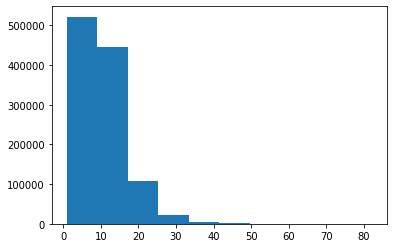

In [ ]:
import nltk
import matplotlib.pyplot as plt
nltk.download('punkt')

# 统计句子长度分布
train_datas = readFromZipFile('snli_1.0/snli_1.0_train.txt')
len_arr = []
for x in train_datas['sentence1']:
    if isinstance(x, str):
        len_arr.append(len(nltk.word_tokenize(x)))

for x in train_datas['sentence2']:
    if isinstance(x, str):
        len_arr.append(len(nltk.word_tokenize(x)))
plt.hist(len_arr)
print(max(len_arr))

虽然训练集最长的句子长度为82，但绝大部分句子不超过40，考虑到lstm的运行效率，我觉得padding长度为30，剩余部分将直接进行截断。

### 1.3 建立词表

预训练词向量采用的是glove

In [ ]:
import pandas as pd
import numpy as np
import nltk

nltk.download("punkt")

# 建立词表
class VocabProcessor():
    def run(self, train_path="snli_1.0/snli_1.0_train.txt", glove_path="../glove/glove.6B.300d.txt"):
        glove = self.processGlove(glove_path)
        vocab = self.buildVocab(train_path, glove)
        return vocab    

    # 读取GloVe文件
    def processGlove(self, glove_path):
        word2idx = {}
        vectors = []
        with open(glove_path) as fp:
            lines = fp.readlines()
            
            for i, line in enumerate(lines):
                line = line.strip('\n').split()
                word2idx[line[0]] = i 
                vectors.append(np.array(list(map(float, line[1:])), dtype=np.float32))
            fp.close()
        
        return {"word2idx":word2idx, "glove_vectors":vectors}

    # 利用训练集建立词表
    def buildVocab(self, train_path, glove):
        vocab = ['<pad>', '<unk>']
        word2idx = {'<pad>':0, '<unk>':1}
        
        datas = readFromZipFile(train_path)

        curr_idx = 2
        for index, line in datas.iterrows():
            # 判断sentence1和sentence2是否是合法的字符串
            if not isinstance(line['sentence1'], str) or not isinstance(line['sentence2'], str):
                continue
            
            # 合并进行处理
            cur_line = line['sentence1'] + ' ' + line['sentence2']

            # 首先进行分词
            text = nltk.word_tokenize(cur_line)

            # 逐个词进行判断
            for word in text:
                # 如果词不在glove的词表里或词已经在词表里，则跳过
                if not (word in glove["word2idx"]) or word in word2idx:
                    continue
                else:
                    vocab.append(word)
                    word2idx[word] = curr_idx
                    curr_idx = curr_idx + 1

        
        # 建立词向量大矩阵
        glove_vectors = np.zeros((len(vocab), 300), dtype=np.float32)

        # 随机初始化<unk>
        glove_vectors[1] = np.random.randn((300))

        for i in range(2, len(vocab)):
            word = vocab[i]
            glove_idx = glove["word2idx"][word]
            glove_vectors[i] = glove["glove_vectors"][glove_idx]

        return {"word2idx":word2idx, "glove_vectors":glove_vectors}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
vocab_processor = VocabProcessor()
glove_vocab = vocab_processor.run()

### 1.5 向量化数据集
标签编码：
- neutral - 0
- contradiction - 1
- entailment - 2

In [ ]:
import torch.utils.data

class SNLIDataset(torch.utils.data.Dataset):
    label_dict = {"neutral":0, 
                  "contradiction":1, 
                  "entailment":2}
    
    
    def __init__(self, path, vocab, padding_length):
        super(SNLIDataset).__init__()
        self.datas = []
        self.padding_length = padding_length
        self.vocab = vocab
        datas = readFromZipFile(path)

        for index, line in datas.iterrows():
             # 判断数据是否合法
            if not isinstance(line['sentence1'], str) or not isinstance(line['sentence2'], str) or line["gold_label"] not in self.label_dict:
                continue

            self.datas.append({"sentence1":self._tokenize(line['sentence1']),
                               "sentence2":self._tokenize(line['sentence2']),
                               "label":self.label_dict[line['gold_label']]})
    
    def __getitem__(self, index):
        data = self.datas[index]
        sentence1_text = torch.Tensor(data["sentence1"][0]).long()
        sentence2_text = torch.Tensor(data["sentence2"][0]).long()
        sentence1_mask = torch.Tensor(data["sentence1"][1]).bool()
        sentence2_mask = torch.Tensor(data["sentence2"][1]).bool()
        label = data["label"]
        return (sentence1_text, sentence1_mask, sentence2_text, sentence2_mask, label)
    
    def __len__(self):
        return len(self.datas)

    def _tokenize(self, line):
        result = np.zeros((self.padding_length), dtype=np.long)   # <pad> : 0
        mask = np.ones((self.padding_length), dtype=np.bool)

        # 分词
        text = nltk.word_tokenize(line)
        length = min(len(text), self.padding_length)
        mask[length:] = 0

        # 序列化
        unk_idx = self.vocab['word2idx']['<unk>']
        for i, word in enumerate(text):
            if i >= self.padding_length:
                break

            if not (word in self.vocab["word2idx"]): # 不在词表的词
                result[i] = unk_idx
            else:
                word_idx = self.vocab['word2idx'][word]
                result[i] = word_idx
        
        return (result, mask)

In [ ]:
train_path = "snli_1.0/snli_1.0_train.txt"
val_path = "snli_1.0/snli_1.0_dev.txt"
test_path = "snli_1.0/snli_1.0_test.txt"

train_dataset = SNLIDataset(train_path, glove_vocab, 40)
val_dataset = SNLIDataset(val_path, glove_vocab, 40)
test_dataset = SNLIDataset(test_path, glove_vocab, 40)

In [ ]:
val_dataset[1]

(tensor([   1,   82,   28, 1878,   62,  144,   74,  558, 1252,   11,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]),
 tensor([   1,  132,   28,  144, 1252,   11,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 tensor([ True,  True,  True,  True,  True,  True, False, False, False, False,
         False, False, False, False, False, Fal

In [ ]:
import pickle

cache = {"glove_vocab":glove_vocab,
         "train_dataset":train_dataset,
         "val_dataset":val_dataset,
         "test_dataset":test_dataset}

# 缓存预处理后的数据，加速多次训练
with open("cache/preprocess.pickle", 'wb') as fp:
    pickle.dump(cache, fp)

In [ ]:
import pickle

# 读取缓存
with open("cache/preprocess.pickle", 'rb') as fp:
    cache = pickle.load(fp)
glove_vocab = cache["glove_vocab"]
train_dataset= cache["train_dataset"]
val_dataset= cache["val_dataset"]
test_dataset= cache["test_dataset"]

## 2. ESIM模型
这里只使用了LSTM+双向注意力机制实现该模型
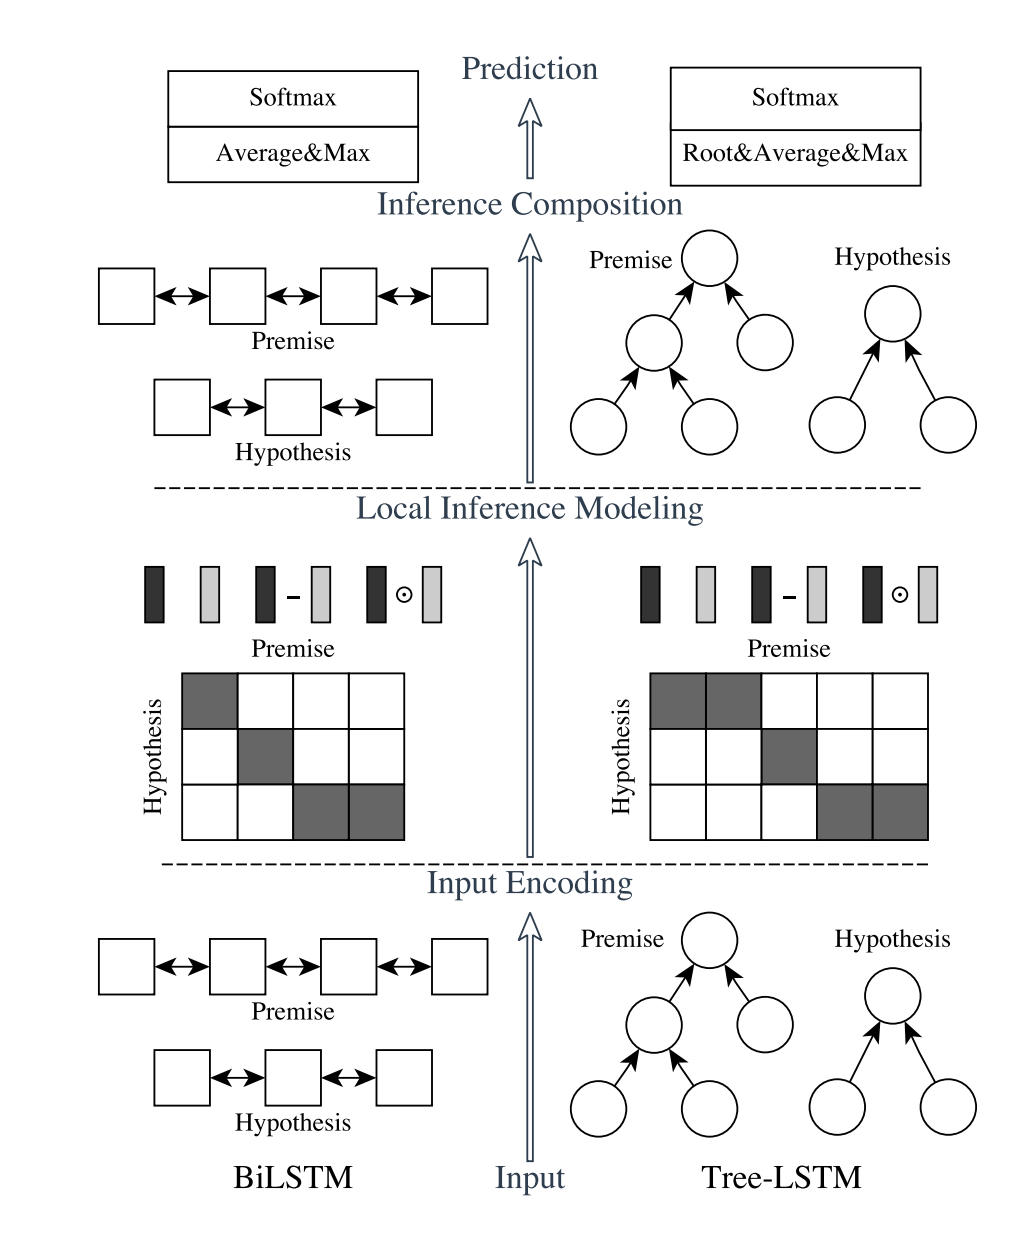

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# 初始化参数
def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data)
        nn.init.constant_(module.bias.data, 0.0)

    elif isinstance(module, nn.LSTM):
        nn.init.xavier_uniform_(module.weight_ih_l0.data)
        nn.init.orthogonal_(module.weight_hh_l0.data)
        nn.init.constant_(module.bias_ih_l0.data, 0.0)
        nn.init.constant_(module.bias_hh_l0.data, 0.0)
        hidden_size = module.bias_hh_l0.data.shape[0] // 4
        module.bias_hh_l0.data[hidden_size:(2*hidden_size)] = 1.0

        if (module.bidirectional):
            nn.init.xavier_uniform_(module.weight_ih_l0_reverse.data)
            nn.init.orthogonal_(module.weight_hh_l0_reverse.data)
            nn.init.constant_(module.bias_ih_l0_reverse.data, 0.0)
            nn.init.constant_(module.bias_hh_l0_reverse.data, 0.0)
            module.bias_hh_l0_reverse.data[hidden_size:(2*hidden_size)] = 1.0 

class ESIM(nn.Module):
    def __init__(self, args, vocab):
        super(ESIM, self).__init__()
        self.args = args

        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(vocab, freeze=True)

        # Input Encoding Layer
        self.encoding = nn.LSTM(input_size=args.embed_size,
                                hidden_size=args.hidden_size,
                                num_layers=1,
                                batch_first=True,
                                bidirectional=True)

        # Feedforward Neural Networks Layer
        self.projection = nn.Sequential(nn.Linear(4*2*args.hidden_size,
                                                  args.hidden_size),
                                        nn.ReLU())

        # Inference Composition Layer
        self.composition = nn.LSTM(input_size=args.hidden_size,
                                   hidden_size=args.hidden_size,
                                   num_layers=1,
                                   batch_first=True,
                                   bidirectional=True)

        # Multilayer Perceptron classifier
        self.classifier = nn.Sequential(nn.Linear(4*2*args.hidden_size,
                                                  args.hidden_size),
                                        nn.Tanh(),
                                        nn.Dropout(p=args.dropout_rate),
                                        nn.Linear(args.hidden_size,
                                                  args.label_num))
        

        # Dropout Layer
        self.dropout = nn.Dropout(args.dropout_rate)

        self.apply(init_weights)

    # bilstm编码
    def _seq_encoding(self, lstm, seqs, seqs_mask):
        outputs, _ = lstm(seqs)
        masked_outputs = outputs * seqs_mask.view(-1, self.args.padded_length, 1)
        return masked_outputs

    def _attention(self, encoded_premise, encoded_hypothesis):
        # Soft Alignment Layer
        e = torch.einsum('bik,bjk->bij', encoded_premise, encoded_hypothesis)

        # premise weight
        premise_weight = F.softmax(e, dim=2)
        attened_premise = torch.einsum("bij,bjk->bik", premise_weight, encoded_hypothesis)

        hypothesis_weight = F.softmax(e, dim=1)
        attened_hypothesis = torch.einsum("bij,bik->bjk", hypothesis_weight, encoded_premise)

        return attened_premise, attened_hypothesis

    def forward(self, 
                premise, 
                premise_mask,
                hypothesis,
                hypothesis_mask):
        # Embedding Layer
        # (batch_size, length) -> (batch_size, length, embed_dim)
        embed_premise = self.embedding(premise)
        embed_hypothesis = self.embedding(hypothesis)


        # Input Encoding Layer
        # (batch_size, length, embed_dim) -> (batch_size, length, 2 * hidden_dim)
        encoded_premise = self._seq_encoding(self.encoding, 
                                             embed_premise, 
                                             premise_mask)
        encoded_hypothesis = self._seq_encoding(self.encoding, 
                                                embed_hypothesis,
                                                hypothesis_mask)
        
        # dropout
        encoded_premise = self.dropout(encoded_premise)
        encoded_hypothesis = self.dropout(encoded_hypothesis)


        # Local Inference Modeling Layer
        # Attention
        attened_premise, attened_hypothesis = self._attention(encoded_premise, encoded_hypothesis)

        # dropout
        attened_premise = self.dropout(attened_premise)
        attened_hypothesis = self.dropout(attened_hypothesis)

        # Enhancement
        # (batch_size, length, 2 * hidden_dim) -> (batch_size, length, 4 * 2 * hidden_dim)
        enhanced_premise = torch.cat([encoded_premise,
                                      attened_premise,
                                      encoded_premise - attened_premise,
                                      encoded_premise * attened_premise], dim=-1)
        enhanced_hypothesis = torch.cat([encoded_hypothesis,
                                         attened_hypothesis,
                                         encoded_hypothesis - attened_hypothesis,
                                         encoded_hypothesis * attened_hypothesis], dim=-1)
        
        # dropout
        enhanced_premise = self.dropout(enhanced_premise)
        enhanced_hypothesis = self.dropout(enhanced_hypothesis)

        # Projection
        # (batch_size, length, 4 * 2 * hidden_dim) -> (batch_size, length, hidden_dim)
        projected_premise = self.projection(enhanced_premise)
        projected_hypothesis = self.projection(enhanced_hypothesis)

        # dropout
        projected_premise = self.dropout(projected_premise)
        projected_hypothesis = self.dropout(projected_hypothesis)


        # Inference Composition Layer
        # (batch_size, length, hidden_dim) -> (batch_size, length, 2 * hidden_dim)
        composited_premise = self._seq_encoding(self.composition, 
                                                projected_premise, 
                                                premise_mask)
        composited_hypothesis = self._seq_encoding(self.composition, 
                                                   projected_hypothesis,
                                                   hypothesis_mask)
        
        # dropout
        composited_premise = self.dropout(composited_premise)
        composited_hypothesis = self.dropout(composited_hypothesis)
        
        # Pooling
        # (batch_size, length, 2 * hidden_dim) -> (batch_size, 2 * hidden_dim)
        masked_composited_premise = composited_premise * premise_mask.view(-1, self.args.padded_length, 1)
        masked_composited_hypothesis =  composited_hypothesis * hypothesis_mask.view(-1, self.args.padded_length, 1)
        
        v_a_ave = torch.sum(masked_composited_premise, dim=1) / torch.sum(premise_mask, dim=1).view(-1, 1)
        v_a_max, _ = torch.max(torch.masked_fill(composited_premise, ~premise_mask.view(-1, self.args.padded_length, 1), value=torch.tensor(-1e9)), dim=1)
        
        v_b_ave = torch.sum(masked_composited_hypothesis, dim=1) / torch.sum(hypothesis_mask, dim=1).view(-1, 1)
        v_b_max, _ = torch.max(torch.masked_fill(composited_hypothesis, ~hypothesis_mask.view(-1, self.args.padded_length, 1), value=torch.tensor(-1e9)), dim=1)

        # (batch_size, 2 * hidden_dim) -> (batch_size, 4 * 2 * hidden_dim)
        v = torch.cat([v_a_ave, v_a_max, v_b_ave, v_b_max], dim=-1)

        # dropout
        v = self.dropout(v)
        
        # MLP Layer
        # (batch_size, 4 * 2 * hidden_dim) -> (batch_size, 3)
        out = self.classifier(v)
        
        return out

## 3. 训练函数

In [ ]:
from tqdm import tqdm

def train_progress(args, model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, device):
    train_acc_arr = []
    train_loss_arr = []
    val_acc_arr = []
    val_loss_arr = []
    best_val_acc = 0.
    best_val_epoch = -1
    
    for epoch in range(args.epochs):
        print(f"Epoch {epoch}:")

        # Training
        train_len = 0
        train_loss = 0.
        train_acc = 0.

        model.train()
        for step, datas in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            optimizer.zero_grad()
            
            premise, premise_mask, hypothesis, hypothesis_mask, labels = [data.to(device) for data in datas]
            
            labels = labels.cpu()
            output = model(premise, 
                           premise_mask, 
                           hypothesis, 
                           hypothesis_mask).cpu()
            loss = criterion(output, labels)
            pred = torch.argmax(output.view(-1, args.label_num), dim=-1)
            acc = (pred == labels).float().sum()
            
            # 训练
            loss.backward()
            optimizer.step()

            # 统计结果
            size = labels.numel()
            train_len += size
            train_loss += loss.item()
            train_acc += acc
        
        train_loss = train_loss / train_len
        train_acc = train_acc / train_len
        train_loss_arr.append(train_loss)
        train_acc_arr.append(train_acc)
        print(f"Train: | loss: {train_loss} | acc: {train_acc}")

        # Validation
        val_len = 0
        val_loss = 0.
        val_acc = 0.

        model.eval()
        with torch.no_grad():
            for step, datas in enumerate(val_dataloader):
                premise, premise_mask, hypothesis, hypothesis_mask, labels = [data.to(device) for data in datas]
            
                labels = labels.cpu()
                output = model(premise, 
                           premise_mask, 
                           hypothesis, 
                           hypothesis_mask).cpu()
                loss = criterion(output, labels)
                pred = torch.argmax(output.view(-1, args.label_num), dim=-1)
                acc = (pred == labels).float().sum()

                # 统计结果
                size = labels.numel()
                val_len += size
                val_loss += loss.item()
                val_acc += acc
            
        val_loss = val_loss / val_len
        val_acc = val_acc / val_len
        val_loss_arr.append(val_loss)
        val_acc_arr.append(val_acc)
        print(f"Validation: | loss: {val_loss} | acc: {val_acc}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_epoch = epoch
            torch.save(model.state_dict(), "models/best_model.pth")
        
        # Early stop
        if epoch - best_val_epoch >= 5:
            print("Early Stop!")
            break

    # Test
    best_checkpoint = torch.load("models/best_model.pth")
    model.load_state_dict(best_checkpoint)
    test_len = 0
    test_loss = 0.
    test_acc = 0.

    model.eval()
    with torch.no_grad():
        for step, datas in enumerate(test_dataloader):
            premise, premise_mask, hypothesis, hypothesis_mask, labels = [data.to(device) for data in datas]
            
            labels = labels.cpu()
            output = model(premise, 
                        premise_mask, 
                        hypothesis, 
                        hypothesis_mask).cpu()
            loss = criterion(output, labels)
            pred = torch.argmax(output.view(-1, args.label_num), dim=-1)
            acc = (pred == labels).float().sum()

            # 统计结果
            size = labels.numel()
            test_len += size
            test_loss += loss.item()
            test_acc += acc
        
    test_loss = test_loss / test_len
    test_acc = test_acc / test_len
    print(f"\n\nFinal test: | loss: {test_loss} | acc: {test_acc}")
    return (train_loss_arr, train_acc_arr), (val_loss_arr, val_acc_arr)

## 4. 训练和分析
### 4.1 超参数

In [ ]:
class Arguments():
    epochs = 50
    batch_size = 256
    lr = 5e-4
    embed_size = 300
    hidden_size = 300
    padded_length = 40
    dropout_rate = 0.5
    label_num = 3
    max_norm = 10.0

### 4.2 训练过程

In [ ]:
import torch.optim

args = Arguments()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab =  torch.Tensor(glove_vocab["glove_vectors"])
model = ESIM(args, vocab)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model.cuda()

In [ ]:
import torch.utils.data

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=False)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=False)

train_record, val_record = train_progress(args=args, 
                                          model=model,
                                          optimizer=optimizer,
                                          criterion=criterion,
                                          train_dataloader=train_dataloader, 
                                          val_dataloader=val_dataloader, 
                                          test_dataloader=test_dataloader, 
                                          device=device)

Epoch 0:


100%|██████████| 2146/2146 [03:33<00:00, 10.03it/s]


Train: | loss: 0.002986725652929027 | acc: 0.6633179187774658
Validation: | loss: 0.0027747296434281147 | acc: 0.7021946907043457
Epoch 1:


100%|██████████| 2146/2146 [03:33<00:00, 10.04it/s]


Train: | loss: 0.0024551478956233164 | acc: 0.742393434047699
Validation: | loss: 0.0025389679646835995 | acc: 0.7370452880859375
Epoch 2:


100%|██████████| 2146/2146 [03:33<00:00, 10.03it/s]


Train: | loss: 0.0022665991452912823 | acc: 0.7655767202377319
Validation: | loss: 0.002225633983906632 | acc: 0.7793131470680237
Epoch 3:


100%|██████████| 2146/2146 [03:34<00:00, 10.01it/s]


Train: | loss: 0.002155747190797441 | acc: 0.779656708240509
Validation: | loss: 0.0020747876002570036 | acc: 0.7933346629142761
Epoch 4:


100%|██████████| 2146/2146 [03:34<00:00, 10.01it/s]


Train: | loss: 0.0020678484620889844 | acc: 0.7903181910514832
Validation: | loss: 0.002101006894377135 | acc: 0.7987197637557983
Epoch 5:


100%|██████████| 2146/2146 [03:34<00:00, 10.01it/s]


Train: | loss: 0.002006118285058389 | acc: 0.7973281741142273
Validation: | loss: 0.0019398289249089162 | acc: 0.8123348951339722
Epoch 6:


100%|██████████| 2146/2146 [03:34<00:00, 10.02it/s]


Train: | loss: 0.0019532047772693054 | acc: 0.803735613822937
Validation: | loss: 0.001877657074410846 | acc: 0.8205649256706238
Epoch 7:


100%|██████████| 2146/2146 [03:34<00:00, 10.02it/s]


Train: | loss: 0.0019029949202765963 | acc: 0.8101394176483154
Validation: | loss: 0.0019119159976923959 | acc: 0.8144686222076416
Epoch 8:


100%|██████████| 2146/2146 [03:34<00:00, 10.00it/s]


Train: | loss: 0.0018609057698724804 | acc: 0.8148193955421448
Validation: | loss: 0.0018301976905608414 | acc: 0.8204632997512817
Epoch 9:


100%|██████████| 2146/2146 [03:34<00:00, 10.00it/s]


Train: | loss: 0.0018243771353483702 | acc: 0.8190224766731262
Validation: | loss: 0.001828792351480665 | acc: 0.8218858242034912
Epoch 10:


100%|██████████| 2146/2146 [03:34<00:00, 10.01it/s]


Train: | loss: 0.0017866399480019556 | acc: 0.8228068351745605
Validation: | loss: 0.0018676918494316215 | acc: 0.8235114812850952
Epoch 11:


100%|██████████| 2146/2146 [03:34<00:00, 10.02it/s]


Train: | loss: 0.0017507104170775918 | acc: 0.8269407749176025
Validation: | loss: 0.0018072351737614448 | acc: 0.8272708654403687
Epoch 12:


100%|██████████| 2146/2146 [03:34<00:00, 10.01it/s]


Train: | loss: 0.0017114263896467906 | acc: 0.831506073474884
Validation: | loss: 0.001814304822418075 | acc: 0.8274741172790527
Epoch 13:


100%|██████████| 2146/2146 [03:34<00:00, 10.00it/s]


Train: | loss: 0.0016791098123287995 | acc: 0.8357400894165039
Validation: | loss: 0.0017729989519644452 | acc: 0.8312335014343262
Epoch 14:


100%|██████████| 2146/2146 [03:34<00:00, 10.00it/s]


Train: | loss: 0.001648016387559359 | acc: 0.8389674425125122
Validation: | loss: 0.0017915257192002009 | acc: 0.8279821276664734
Epoch 15:


100%|██████████| 2146/2146 [03:34<00:00, 10.00it/s]


Train: | loss: 0.0016160693866843004 | acc: 0.8425770998001099
Validation: | loss: 0.001778045385694436 | acc: 0.8320463299751282
Epoch 16:


100%|██████████| 2146/2146 [03:34<00:00, 10.02it/s]


Train: | loss: 0.0015812932438982084 | acc: 0.8468857407569885
Validation: | loss: 0.0018340703240014556 | acc: 0.8272708654403687
Epoch 17:


100%|██████████| 2146/2146 [03:34<00:00, 10.01it/s]


Train: | loss: 0.0015508773575775014 | acc: 0.8501204252243042
Validation: | loss: 0.001781195953255188 | acc: 0.8311318755149841
Epoch 18:


100%|██████████| 2146/2146 [03:34<00:00,  9.99it/s]


Train: | loss: 0.0015180134694658344 | acc: 0.8533641695976257
Validation: | loss: 0.0017879827977970977 | acc: 0.8330624103546143
Epoch 19:


100%|██████████| 2146/2146 [03:34<00:00,  9.99it/s]


Train: | loss: 0.0014894772673842078 | acc: 0.8566625714302063
Validation: | loss: 0.001818021022432874 | acc: 0.8315383195877075
Epoch 20:


100%|██████████| 2146/2146 [03:34<00:00, 10.00it/s]


Train: | loss: 0.0014622911258700797 | acc: 0.8596569299697876
Validation: | loss: 0.0018239680634502277 | acc: 0.8367201685905457
Epoch 21:


100%|██████████| 2146/2146 [03:34<00:00, 10.01it/s]


Train: | loss: 0.0014261828594826671 | acc: 0.8631446361541748
Validation: | loss: 0.0017968279102715359 | acc: 0.8311318755149841
Epoch 22:


100%|██████████| 2146/2146 [03:34<00:00, 10.01it/s]


Train: | loss: 0.0013969555421736166 | acc: 0.8669581413269043
Validation: | loss: 0.0018391302659777552 | acc: 0.8319447040557861
Epoch 23:


100%|██████████| 2146/2146 [03:34<00:00,  9.99it/s]


Train: | loss: 0.0013693461964357514 | acc: 0.8700326085090637
Validation: | loss: 0.0018290859930788059 | acc: 0.8335704207420349
Epoch 24:


100%|██████████| 2146/2146 [03:34<00:00, 10.00it/s]


Train: | loss: 0.0013381519821867702 | acc: 0.8738116025924683
Validation: | loss: 0.0018715872933675157 | acc: 0.8315383195877075
Epoch 25:


100%|██████████| 2146/2146 [03:34<00:00, 10.00it/s]


Train: | loss: 0.0013115987879333654 | acc: 0.8761925101280212
Validation: | loss: 0.001838009069421819 | acc: 0.8339768052101135
Early Stop!


Final test: | loss: 0.0018209738790357928 | acc: 0.8338761925697327


### 4.3 结果分析

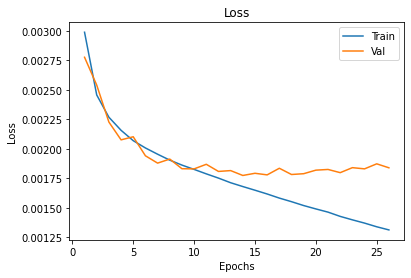

In [ ]:
import matplotlib.pyplot as plt

experiment_epoch = range(1, len(train_record[0]) + 1)
plt.plot(experiment_epoch, train_record[0], label='Train')
plt.plot(experiment_epoch, val_record[0], label='Val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

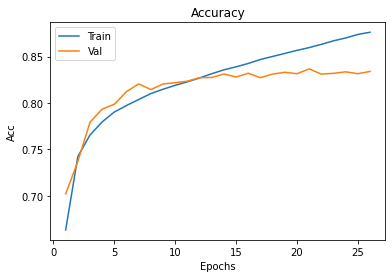

In [ ]:
experiment_epoch = range(1, len(train_record[1]) + 1)
plt.plot(experiment_epoch, train_record[1], label='Train')
plt.plot(experiment_epoch, val_record[1], label='Val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

从上面两张图可以看出，训练集的损失值和正确率都还在变好，但是验证集已经趋向于收敛，说明模型已经过拟合了。测试集上的结果是使用验证集上准确率最高对应的模型参数测出来的，准确率为83.39%，这个结果和论文给出的结果有点差距，可能是batch_size调太大，或者是随机数的问题。